# Olympic Data Analysis and Predictive Machine Learning

This Notebook is exploring a dataset of Olympic data (Sourced from [The Guardian - Kaggle](https://www.kaggle.com/datasets/the-guardian/olympic-games)) and aims to first Explore the data and then build a predictive model to determine if it is possible to predict the results of a future Olympic event using past data.

## Import Libraries

In [1]:
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import count
import seaborn

## Data Loading and Preparation

In [2]:
def DataLoader(dataDirectory):
    dictPath = dataDirectory + "dictionary.csv"
    summerPath = dataDirectory + "summer.csv"
    winterPath = dataDirectory + "winter.csv"

    olympicDict = pd.read_csv(dictPath)
    summerData = pd.read_csv(summerPath)
    winterData = pd.read_csv(winterPath)

    return olympicDict, summerData, winterData

olympicDict, summerData, winterData = DataLoader("Data/")

In [46]:
def findUndefinedCountries(data):
    undefinedCountries = data[~data["Country"].isin(olympicDict["Code"])]
    return undefinedCountries["Country"].drop_duplicates().reset_index(drop=True)

summerUndefinedCountries = findUndefinedCountries(summerData)
winterUndefinedCountries = findUndefinedCountries(winterData)

pd.concat([summerUndefinedCountries, winterUndefinedCountries]).drop_duplicates().reset_index(drop=True)



0     ZZX
1     BOH
2     ANZ
3     RU1
4     TCH
5     YUG
6     ROU
7     URS
8     EUA
9     BWI
10    GDR
11    FRG
12    EUN
13    IOP
14    SRB
15    NaN
16    TTO
17    MNE
18    SGP
Name: Country, dtype: object

19 Country codes are included in the data that do not exist in the dictionary. There are several reasons that this may have occured, and can be fixed. 
For Example, athletes from `URS` represented the Soviet Union at relevant Olympics

In [52]:
def dataCleanup(data):
    # There are only 4 rows that have `Nan` data. This is because the dataset included `pending` positions - where the  athlete had not yet been assigned. These can be dropped
    data = data.drop(data[data["Athlete"] == "Pending"].index)
    # This has removed 3 of the 4 rows containing Missing data. the last one has an athlete, but no country.
    # The athlete is KUDUKHOV, Besik, who represented Russia. This will be used to fill the missing data.
    data = data.fillna("RUS")

    # Countries with codes that do not exist in the dictionary will now be manually reassigned. Some liberties will be taken, such as 

    return data

summerData = dataCleanup(summerData)
# summerData = dataCleanup(summerData)
# winterData = dataCleanup(winterData)

In [3]:
def dataAggregation(data):
    # Medal values are being defined in a way that higher = better. This will make it easier for analysis later.
    medalCountDict = {"Bronze" : 1, "Silver" : 2, "Gold" : 3}
    # Map the numerical values of the medals based on the string defined in the dictionary above.
    data["MedalVal"] = data["Medal"].map(medalCountDict)

    # Select only necessary data
    data = data[["Year", "Sport", "Country", "Medal", "MedalVal"]] #  "Discipline", "Event", could also be included if desired

    # Group data each Olympics, each Country, for each sport, and count the total number of medals (higher is better).
    medalCounts = data.groupby(["Year", "Country", "Sport"])["MedalVal"].sum().reset_index()

    # Calculate each countries Total Number of medals at each Olympics
    overallResults = medalCounts.groupby(["Year", "Country"])["MedalVal"].sum().reset_index()
    
    # Create a Rank Based on this number
    overallResults["Rank"] = overallResults.groupby("Year")["MedalVal"].rank(ascending = False, method = "min").astype(int)

    # Reorder the rows to make the data easier to read / use
    overallResults = overallResults.sort_values(by = ["Year", "Rank"]).reset_index(drop=True)


    return medalCounts, overallResults

summerMedalCounts, summerOverallResults = dataAggregation(summerData)
winterMedalCounts, winterOverallResults = dataAggregation(winterData)

## Data Exploration

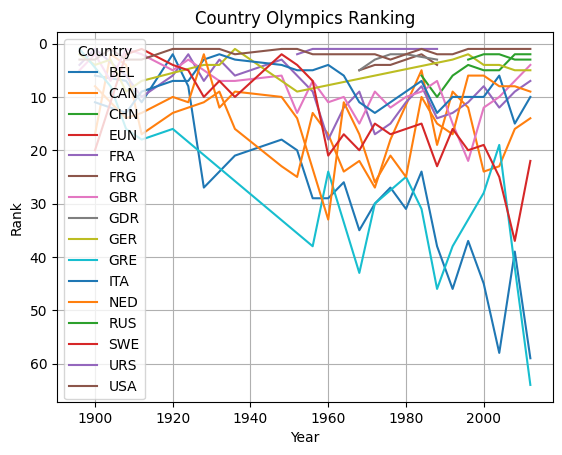

In [4]:
def plotCountryRankingsOverTime(data, positionThreshold):
    # Group by countries
    countryGroupedData = data.groupby("Country").filter(lambda country: country["Rank"].min() <= positionThreshold)
    countryGroupedData = countryGroupedData.groupby("Country")
    # Create a line for each country
    for name, group in countryGroupedData:
        plt.plot(group["Year"], group["Rank"], label = name)

    plt.title("Country Olympics Ranking")
    plt.xlabel("Year")
    plt.ylabel("Rank")
    plt.gca().invert_yaxis() # Invert the Y-Axis to show rank 1 at the top
    plt.legend(title = "Country")
    plt.grid(True)

    plt.show()
    

plotCountryRankingsOverTime(summerOverallResults, 2)

## Machine Learning